In [ ]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [ ]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel
from gammapy.irf import EDispKernel, PSFMap
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion
from hawc_dataset import HAWCMapDataset
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
)
sys.path.append('/d22/hin/vikasj78/J1809-193_Analysis/hess-j1813/scripts')
from vikas_utils import get_excluded_regions

In [ ]:
spatial_model = PointSpatialModel(
    lon_0="83.63 deg",
    lat_0="22.01 deg",
    frame="icrs"
)

spectral_model = LogParabolaSpectralModel(
        amplitude="2.6e-13 TeV-1 cm-2 s-1",
        alpha=2.65,
        beta=0.1,
        reference="1 TeV"
)

spectral_model.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
spectral_model.beta.error = 0.015
spectral_model.alpha.error = 0.019

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name='crab model')

In [ ]:
ra_obj = 83.6333
dec_obj = 22.0144
name_obj = 'Crab Nebula'
target = SkyCoord(ra_obj, dec_obj, frame='icrs', unit='deg')

In [ ]:
config = 'std_ImPACT_fullEnclosure'
outputBase = '/lfs/l2/hawc/users/vikasj78/gammapyData/crab/'
plotDir = 'plots/'

In [ ]:
# Get run list
runs = np.loadtxt('crab_mintels3_maxRad1deg_spectal.lis', usecols=(0,), dtype=int)
# Load FITS data
basedir = '$HESS_DATA/hess1/{}'.format(config)
ds = DataStore.from_dir(basedir)
obs_list = ds.get_observations(runs)

In [ ]:
def save(fig, filename, left=0.15, bottom=0.15, top=0.95, right=0.95):
    savedir = '{}'.format(plotDir)
    fig.subplots_adjust(left=left, bottom=bottom, top=top, right=right)
    for form in ['png', 'pdf']:
        fig.savefig('{}/crab_joint_hess_hawc_{}.{}'.format(plotDir, filename, form))

In [ ]:
#Let's look around for the zenith, offset distribution and the livetime
pointingZen, pointingOffset, obsLiveTime = np.array([[obs.pointing_zen.value, 
                                         obs.pointing_radec.separation(target).value,
                                         obs.observation_live_time_duration.to(u.hour).value] for obs in obs_list]).T
print("Total live time: ", obsLiveTime.sum(), "hrs" )
fig, axes = plt.subplots(1,2,figsize=(9,3))
ax1 = axes[0]
ax2 = axes[1]
ax1.hist(pointingZen, bins=np.linspace(0, 90, 15), histtype='step', lw=2)
ax1.set_xlabel('Zenith angle [deg]')
ax1.set_ylabel('Number of runs')
ax1.grid(ls='--')
ax2.hist(pointingOffset, bins=np.linspace(0, 3, 30), histtype='step', lw=2)
ax2.set_xlabel('Offset angle [deg]')
ax2.set_ylabel('Number of runs')
ax2.grid(ls='--')
save(fig,'zenith_and_offset_distribution')

In [9]:
# Define map geometry (spatial and energy binning)
ebins = np.logspace(-0.25, 2, 18)
pix_size = 0.02
eaxis = MapAxis.from_edges(ebins, unit='TeV', name='energy', interp='log')

geom = WcsGeom.create(
    skydir=(ra_obj, dec_obj),
    binsz=pix_size,
    width=(2, 2),
    frame='icrs',
    proj='CAR',
    axes=[eaxis],
)
max_offset = 1.5 * u.deg

In [10]:
%%time
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=max_offset)
dataset_stacked = MapDataset.create(geom=geom)

for obs in obs_list:
    geom_cutout = geom.cutout(position=obs.pointing_radec, width=10*u.deg)
    reference = MapDataset.create(geom=geom_cutout)

    dataset = maker.run(reference, obs)
    dataset = maker_safe_mask.run(dataset, obs)

    dataset_stacked.stack(dataset)
    dataset.write('{}/dataset-obs-{}.fits.gz'.format(outputBase, obs.obs_id), overwrite=True)

dataset_stacked.write('{}/dataset-stacked.fits.gz'.format(outputBase), overwrite=True)

CPU times: user 2min 17s, sys: 4.48 s, total: 2min 21s
Wall time: 2min 57s


In [12]:
print(dataset_stacked.background_model.evaluate().data.shape)
print(dataset_stacked.counts.data.shape)
print(dataset.exposure.data.shape)

(17, 100, 100)
(17, 100, 100)
(17, 100, 100)


In [10]:
dataset_stacked = MapDataset.read('{}/dataset-stacked.fits.gz'.format(outputBase))
print(dataset_stacked)

MapDataset
----------

  Name                            : A9ISL-oU 

  Total counts                    : 128957 
  Total predicted counts          : 115738.29
  Total background counts         : 115738.29

  Exposure min                    : 1.19e+10 m2 s
  Exposure max                    : 1.57e+11 m2 s

  Number of total bins            : 170000 
  Number of fit bins              : 170000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 105829.78

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: BackgroundModel
  
    Name                      : A9ISL-oU-bkg
    Datasets names            : ['A9ISL-oU']
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  


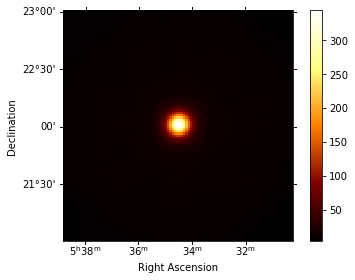

In [11]:
w_gauss = 0.05 * u.deg
# Counts map
fig = dataset_stacked.counts.sum_over_axes().smooth(w_gauss).plot(add_cbar=True)[0]
save(fig, 'counts_map')

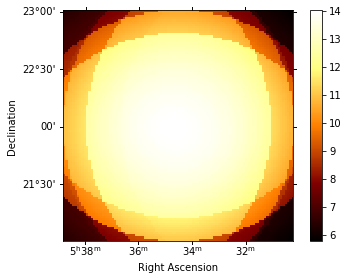

In [12]:
# Background model map, before fit
fig = dataset_stacked.background_model.map.sum_over_axes().plot(add_cbar=True)[0]
save(fig, 'no_fit_bkg_map')

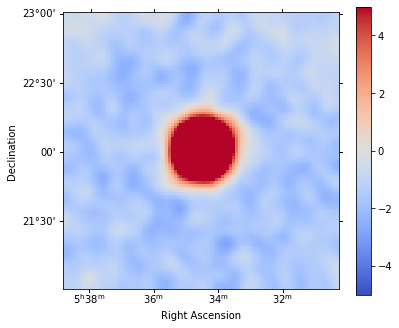

In [13]:
# Residual excess map before fitting
# (no energy cut applied)
dataset_stacked.plot_residuals(smooth_radius=w_gauss, figsize=(6,5))
fig = plt.gcf()
save(fig, 'no_fit_excess_map')

In [14]:
#get the exclusion regions 
hap_exclusion_regions = get_excluded_regions(ra_obj, dec_obj, 5)
excl_regions = []
excl_regions_without_crab = []
for rex in hap_exclusion_regions:
    center = SkyCoord(rex.ra, rex.dec, unit='deg', frame='icrs')
    region = CircleSkyRegion(center=center, radius=rex.radius*u.deg)
    excl_regions.append(region)
    if not rex.name == 'HESSJ0534+220':
        excl_regions_without_crab.append(region)
for rex in hap_exclusion_regions:
    print(rex.name, rex.ra, rex.dec, rex.radius)

HESSJ0534+220 83.63371975398398 22.014235377577982 0.3
HIP_26451 84.41126 21.142570000000003 0.2
HIP_25539 81.90876 21.93698 0.2
HIP_27913 88.59584 20.27619 0.2


In [15]:
# Read energy thresholds from files
bias_thr_id, bias_thr = np.loadtxt('thresholds_bias_{}.txt'.format(config), unpack=True)
bias_thresholds = {k:v for k,v in zip(bias_thr_id.astype(int), bias_thr)}
energy_thresholds = bias_thresholds
#print(energy_thresholds.values())
min_energy = min(energy_thresholds.values())

In [16]:
# Compute thresholds that would actually be applied, given the analysis energy binning
applied_fine_thresholds = np.array([ebins[ebins > thr_val][0] for thr_val in energy_thresholds.values()])
#print(applied_fine_thresholds)
unique_applied_fine_thresholds = np.unique(applied_fine_thresholds)
#print(unique_applied_fine_thresholds)
#print('Threshold [TeV]  Number of observations')
for thr_val in unique_applied_fine_thresholds:
    print('{:.4f}           {}'.format(thr_val, (applied_fine_thresholds == thr_val).sum()))

0.5623           74
0.7627           55
1.0344           13
1.4030           6
1.9029           2


In [17]:
# Reduce this to only 4 unique thresholds
unique_applied_thresholds = np.array([0.6, 0.8, 1.1, 2.0])
tmp_bins = np.array([0.1]+list(unique_applied_thresholds)) + 0.01
idx = np.digitize(applied_fine_thresholds, bins=tmp_bins)-1
applied_thresholds = unique_applied_thresholds[idx]
#print(applied_thresholds)
for thr_val in unique_applied_thresholds:
    print('{:.4f}           {}'.format(thr_val, (applied_thresholds == thr_val).sum()))

0.6000           74
0.8000           55
1.1000           13
2.0000           8


In [18]:
geom_2d = geom.slice_by_idx(dict(energy=1))
#print(geom_2d)
excl_mask_2d = Map.from_geom(geom_2d, data=geom_2d.region_mask(excl_regions, inside=False))
#print(excl_mask_2d)

In [19]:
%%time
# Fit background for each observation
bgfit_datasets = []
for i,obs in enumerate(obs_list):
    obs_id = obs.obs_id
    dataset = MapDataset.read('{}/dataset-obs-{}.fits.gz'.format(outputBase, obs.obs_id))
    dataset.background_model.tilt.frozen = False

    #exclusion region masks and safe energy range masks are applied
    dataset.mask_safe.data[:] &= excl_mask_2d.data
    emask = eaxis.edges[:-1] >= applied_fine_thresholds[i]*u.TeV
    dataset.mask_safe.data[~emask,:,:] = False
    #to the remaining part of the data we fit the background model
    fit = Fit([dataset])
    result = fit.run()

    bgfit_datasets.append(dataset)

CPU times: user 2min 2s, sys: 6.07 s, total: 2min 8s
Wall time: 2min 16s


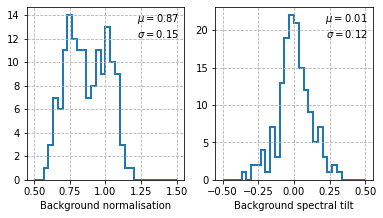

In [20]:
bg_norms, bg_tilts = np.array([ds.models.parameters.values[:2] for ds in bgfit_datasets]).T

fig_bg_fits, axes = plt.subplots(1,2,figsize=(6,3))
ax1 = axes[0]
ax2 = axes[1]
ax1.hist(bg_norms, bins=np.linspace(0.5, 1.5, 31), histtype='step', lw=2)
ax1.set_xlabel('Background normalisation')
ax1.grid(ls='--')
ax1.text(0.97, 0.97, '$\,\mu={:.2f}$\n$\sigma={:.2f}$'.format(np.mean(bg_norms), np.std(bg_norms)),
         ha='right', va='top', transform=ax1.transAxes)
ax2.hist(bg_tilts, bins=np.linspace(-0.5, 0.5, 31), histtype='step', lw=2)
ax2.set_xlabel('Background spectral tilt')
ax2.grid(ls='--')
ax2.text(0.97, 0.97, '$\,\mu={:.2f}$\n$\sigma={:.2f}$'.format(np.mean(bg_tilts), np.std(bg_tilts)),
         ha='right', va='top', transform=ax2.transAxes)

save(fig_bg_fits, 'bkg_fit_pars')

In [21]:
%%time
# Stack datasets
dataset_bgfit_stacked = MapDataset.create(geom=geom)
stacked_exposure = np.zeros_like(dataset_bgfit_stacked.exposure.data)

for i,(obs,dataset) in enumerate(zip(obs_list, bgfit_datasets)):
    emask = eaxis.edges[:-1] >= applied_fine_thresholds[i]*u.TeV
    mask_obs_max_offset = geom_2d.region_mask(
        [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
    )

    dataset.mask_safe.data[emask] = dataset.mask_safe.data[emask] | mask_obs_max_offset

    # it can happen that pixels very far away from the pointing are nan/very large. set those to zero.
    assert np.isfinite(dataset.background_model.map.data[dataset.mask_safe.data]).all()
    dataset.background_model.map.data[~dataset.mask_safe.data] = 0.0

    # Stack exposure manually. Implicitly assuming E_reco = E_true here...
    stacked_exposure[dataset.mask_safe.data] += dataset.exposure.data[dataset.mask_safe.data]
    dataset_bgfit_stacked.stack(dataset)

# Manually overwrite the exposure of the stacked dataset
# This version takes into account the energy thresholds, assuming reco and true energy are equal
dataset_bgfit_stacked.exposure.data = stacked_exposure
dataset_bgfit_stacked.write('{}/dataset-bgfit-stacked.fits.gz'.format(outputBase), overwrite=True)

CPU times: user 7.83 s, sys: 424 ms, total: 8.25 s
Wall time: 8.78 s


In [22]:
dataset_bgfit_stacked = MapDataset.read('{}/dataset-bgfit-stacked.fits.gz'.format(outputBase))

In [23]:
# Attach model to dataset
dataset_bgfit_stacked.models.append(model)

In [24]:
# Also fit spectral tilt of background model
dataset_bgfit_stacked.models.parameters['tilt'].frozen = False

In [25]:
dataset_bgfit_stacked.models.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.000e+00,,0.000e+00,nan,False,0.000e+00
tilt,0.000e+00,,nan,nan,False,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
amplitude,2.600e-13,cm-2 s-1 TeV-1,nan,nan,False,7.000e-15
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
alpha,2.650e+00,,nan,nan,False,1.900e-02
beta,1.000e-01,,nan,nan,False,1.500e-02
lon_0,8.363e+01,deg,nan,nan,False,0.000e+00
lat_0,2.201e+01,deg,-9.000e+01,9.000e+01,False,0.000e+00


In [26]:
%%time
# Perform stacked fit
fit = Fit([dataset_bgfit_stacked])
result = fit.run(optimize_opts=dict(print_level=1))

------------------------------------------------------------------
| FCN = 5.194E+04               |     Ncalls=644 (644 total)     |
| EDM = 0.0002 (Goal: 1E-05)    |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 22.8 s, sys: 466 ms, total: 23.3 s
Wall time: 23.5 s


In [27]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.001e+00,,0.000e+00,nan,False,4.160e-03
tilt,2.351e-03,,nan,nan,False,4.808e-03
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
amplitude,4.064e-11,cm-2 s-1 TeV-1,nan,nan,False,3.338e-13
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
alpha,2.650e+00,,nan,nan,False,2.206e-02
beta,4.878e-02,,nan,nan,False,1.069e-02
lon_0,8.363e+01,deg,nan,nan,False,3.187e-04
lat_0,2.202e+01,deg,-9.000e+01,9.000e+01,False,2.882e-04


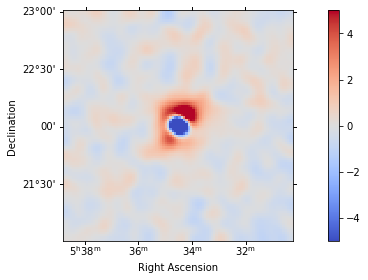

In [28]:
# Residual excess map after the fit (clipped at +- 2 counts)
dataset_bgfit_stacked.plot_residuals(method='diff', smooth_radius=w_gauss)
fig = plt.gcf()
ax = fig.axes[0]
save(fig, 'residual_after_fit')

In [29]:
ref_model = LogParabolaSpectralModel(
    amplitude="2.54e-13 TeV-1 cm-2 s-1",
    alpha=2.646,
    beta=0.104,
    reference="7 TeV"
)
ref_model.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
ref_model.beta.error = 0.015
ref_model.alpha.error = 0.019

In [30]:
%%time
#HESS flux points
flux_points_hess = FluxPointsEstimator(
    e_edges=eaxis.edges,  source="crab model").run([dataset_bgfit_stacked])
flux_points_hess.table["is_ul"] = flux_points_hess.table["ts"] < 4

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/gammapy/estimators/parameter_estimator.py:172: RuntimeWarning: invalid value encountered in sqrt
  {"sqrt_ts": np.sqrt(res), "ts": res, "null_value": null_value}


CPU times: user 30.2 s, sys: 288 ms, total: 30.5 s
Wall time: 30.6 s


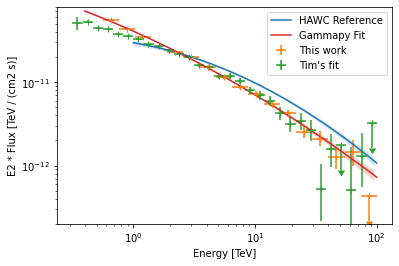

In [31]:
#flux_points_hess.write('fluxPointsHESS.csv')
flux_points_tim = FluxPoints.read('crab_hess1_std_ImPACT_above20000_PL_fit.dat')
ax = ref_model.plot(energy_range=(1, 100) * u.TeV, energy_power=2, label="HAWC Reference")
ref_model.plot_error(energy_range=(1, 100) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
flux_points_hess.plot(ax=ax, energy_power=2, label="This work")
flux_points_tim.plot(ax=ax, energy_power=2, label="Tim's fit")
spectral_model.plot(ax=ax, energy_range=(0.4, 100) * u.TeV, energy_power=2, label="Gammapy Fit")
spectral_model.plot_error(ax=ax, energy_range=(0.4, 100) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())
ax.set_ylim(bottom=2.e-13, top=8.e-11)
plt.legend()
plt.savefig("plots/gammapy-hess-crab.png", dpi=300)

In [32]:
dataset_bgfit_stacked.write('{}/dataset-fitted-stacked.fits.gz'.format(outputBase), overwrite=True)

#### Semi-stacked analysis

In [33]:
%%time
# Stack datasets per applied threshold
datasets_stacked_per_thresh = {i:MapDataset.create(geom=geom) for i in range(len(unique_applied_fine_thresholds))}

for obs,dataset,thr in zip(obs_list, bgfit_datasets, applied_fine_thresholds):
    idx_threshold = np.searchsorted(unique_applied_fine_thresholds, thr)

    emask = eaxis.edges[:-1] >= thr*u.TeV
    # print(obs.obs_id, thr, eaxis.edges[:-1][emask][0].value)
    assert np.isclose(thr, eaxis.edges[:-1][emask][0].value, rtol=1e-3)
    assert np.isclose(thr, unique_applied_fine_thresholds[idx_threshold])
    mask_obs_max_offset = geom_2d.region_mask(
        [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
    )
    dataset.mask_safe.data[emask] = dataset.mask_safe.data[emask] | mask_obs_max_offset

    # it can happen that pixels very far away from the pointing are nan. set those to zero.
    # this should actually already be fixed in the general stacking, but better safe than sorry...
    assert np.isfinite(dataset.background_model.map.data[dataset.mask_safe.data]).all()
    dataset.background_model.map.data[~dataset.mask_safe.data] = 0.0

    datasets_stacked_per_thresh[idx_threshold].stack(dataset)

CPU times: user 5.22 s, sys: 294 ms, total: 5.51 s
Wall time: 5.51 s


In [34]:
for k,ds in datasets_stacked_per_thresh.items():
    ds.write('{}/dataset-bkg-fit-stacked-thresh-{:02d}.fits.gz'.format(outputBase, k),overwrite=True)

In [36]:
datasets_stacked_per_thresh = {}
for i in range(len(unique_applied_fine_thresholds)):
    print(unique_applied_fine_thresholds[i])
    datasets_stacked_per_thresh[i] = MapDataset.read('{}/dataset-bkg-fit-stacked-thresh-{:02d}.fits.gz'.format(outputBase, i))

0.5623413251903491
0.7626985859023444
1.0344413737342368
1.4030037231905739
1.9028815912310253


In [37]:
for ds in datasets_stacked_per_thresh.values():
    ds.models.append(model)

In [38]:
# Parameters before the fit
datasets_stacked_per_thresh[0].models.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.000e+00,,0.000e+00,nan,False,0.000e+00
tilt,0.000e+00,,nan,nan,True,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
amplitude,4.064e-11,cm-2 s-1 TeV-1,nan,nan,False,3.338e-13
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
alpha,2.650e+00,,nan,nan,False,2.206e-02
beta,4.878e-02,,nan,nan,False,1.069e-02
lon_0,8.363e+01,deg,nan,nan,False,3.187e-04
lat_0,2.202e+01,deg,-9.000e+01,9.000e+01,False,2.882e-04


In [39]:
%%time
# Perform fit
fit = Fit(list(datasets_stacked_per_thresh.values()))
result_semi_stacked = fit.run(optimize_opts=dict(print_level=1))

------------------------------------------------------------------
| FCN = 2.382E+05               |     Ncalls=267 (267 total)     |
| EDM = 4.39E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 42.7 s, sys: 238 ms, total: 42.9 s
Wall time: 43.1 s


In [41]:
result_semi_stacked.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.003e+00,,0.000e+00,nan,False,4.983e-03
tilt,0.000e+00,,nan,nan,True,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
amplitude,4.004e-11,cm-2 s-1 TeV-1,nan,nan,False,3.218e-13
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
alpha,2.671e+00,,nan,nan,False,1.926e-02
beta,3.592e-02,,nan,nan,False,9.252e-03
lon_0,8.363e+01,deg,nan,nan,False,3.124e-04
lat_0,2.202e+01,deg,-9.000e+01,9.000e+01,False,2.798e-04


In [42]:
%%time
# Compute flux points for semi stacked(takes long)
fp_semi_stacked = FluxPointsEstimator(e_edges=eaxis.edges,reoptimize=True, source='crab model')
flux_points_semi_stacked = fp_semi_stacked.run(list(datasets_stacked_per_thresh.values()))
flux_points_semi_stacked.table["is_ul"] = flux_points_semi_stacked.table["ts"] < 4

Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed f

CPU times: user 1h 44s, sys: 13.6 s, total: 1h 57s
Wall time: 1h 1min 20s


/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/gammapy/modeling/models/spatial.py:229: RuntimeWarning: invalid value encountered in less
  dx = np.where(dx < 1, 1 - dx, 0)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/gammapy/modeling/models/spatial.py:232: RuntimeWarning: invalid value encountered in less
  dy = np.where(dy < 1, 1 - dy, 0)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/gammapy/modeling/models/spatial.py:229: RuntimeWarning: invalid value encountered in less
  dx = np.where(dx < 1, 1 - dx, 0)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/gammapy/modeling/models/spatial.py:232: RuntimeWarning: invalid value encountered in less
  dy = np.where(dy < 1, 1 - dy, 0)
/lfs/l2/hawc/users/vikasj78/software-hess/gammap

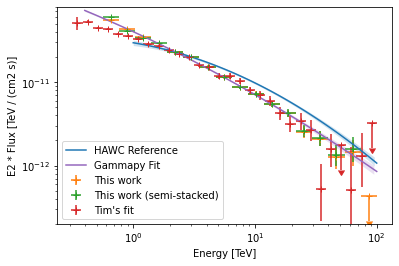

In [46]:
flux_points_tim = FluxPoints.read('crab_hess1_std_ImPACT_above20000_PL_fit.dat')
ax = ref_model.plot(energy_range=(1, 100) * u.TeV, energy_power=2, label="HAWC Reference")
ref_model.plot_error(energy_range=(1, 100) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
flux_points_hess.plot(ax=ax, energy_power=2, label="This work")
flux_points_semi_stacked.plot(ax=ax, energy_power=2, label="This work (semi-stacked)")
flux_points_tim.plot(ax=ax, energy_power=2, label="Tim's fit")
spectral_model.plot(ax=ax, energy_range=(0.4, 100) * u.TeV, energy_power=2, label="Gammapy Fit")
spectral_model.plot_error(ax=ax, energy_range=(0.4, 100) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())
ax.set_ylim(bottom=2.e-13, top=8.e-11)
plt.legend()
plt.savefig("plots/gammapy-hess-crab-semi-stacked.png", dpi=300)